# Model testing

In [1]:
import sys
import os

cur_dir = os.getcwd()
root_dir = os.path.dirname(cur_dir+"/../../")
sys.path.append(root_dir)

In [2]:
# import the necessary packages
import pandas as pd
import tensorflow as tf
from src.data.load_data import load_data
from src.features.labeling import label_encode, one_hot_encode, label_and_one_hot_encode
from src.features.selection import select_features
from src.data.data_scaling import standardize_data, normalize_data
from src.data.split_data import split_data
from src.models.Logistic import train_Logistic
from src.models.NN import train_NN
from src.models.evaluate import evaluate_model
from tensorflow.keras.optimizers import Adam

2024-03-15 13:31:21.433896: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 13:31:21.463601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 13:31:21.463632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 13:31:21.464681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 13:31:21.469749: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 13:31:21.470373: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# load the dataset
df_wo = load_data()
df_w = load_data(weight=True)

In [4]:
# label encode readmitted column
df_wo = label_encode(df_wo, "readmitted", {'NO': 0, '>30': 1, '<30': 1})

# one hot encode the categorical columns
df_wo = one_hot_encode(df_wo)

/home/hasi/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [5]:
# split the data into train and test
X_train_wo, X_test_wo, y_train_wo, y_test_wo = split_data(df_wo, "readmitted")

In [6]:
# standardize the data
X_train_wo, X_test_wo = standardize_data(X_train_wo), standardize_data(X_test_wo)

--------------------
Data Standardized
--------------------
--------------------
Data Standardized
--------------------


In [20]:
X_train_wo

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
97610,0.201288,1.214665,-0.200407,0.859275,0.493307,0.868943,0.292293,0.815832,0,1,...,1,1,0,0,0,0,0,0,0,1
81915,1.205509,0.808560,-0.200407,0.859275,-0.289261,-0.212054,-0.504164,-0.219413,0,1,...,1,1,0,0,0,0,0,0,0,1
46771,-0.802933,-0.460519,-0.786121,-1.717249,-0.289261,-0.212054,-0.504164,-2.289904,0,1,...,0,1,0,0,0,0,0,0,1,1
30433,1.874990,0.300928,-0.786121,0.245817,-0.289261,-0.212054,-0.504164,0.815832,0,0,...,0,1,0,0,0,0,0,0,1,0
2635,-0.468193,0.047112,-0.786121,-0.490332,-0.289261,-0.212054,-0.504164,-0.219413,0,1,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91064,-0.802933,-0.663572,-0.200407,-1.594557,-0.289261,-0.212054,-0.504164,0.815832,0,1,...,0,1,0,0,0,0,0,0,1,0
17122,0.201288,0.453218,1.556735,-0.122258,-0.289261,-0.212054,-0.504164,-2.807526,0,1,...,0,1,0,0,0,0,0,0,1,1
64837,-1.137674,0.605507,-0.786121,-0.613024,-0.289261,-0.212054,-0.504164,-1.772281,0,1,...,0,1,0,0,0,0,0,0,1,0
60903,-0.802933,1.570007,0.385307,-0.122258,-0.289261,-0.212054,-0.504164,0.815832,0,1,...,1,1,0,0,0,0,0,0,0,1


In [21]:
y_train_wo

97610    0
81915    0
46771    0
30433    0
2635     1
        ..
91064    1
17122    0
64837    1
60903    1
23380    0
Name: readmitted, Length: 71236, dtype: int64

# Neural Network

In [9]:
tf.keras.backend.clear_session()

## Learning Rate Tuning

In [7]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

config_1 = [(32, 'relu'), (10, 'relu')]
input_dim, n_ini, epochs, batch_size,  = int(df_wo.shape[-1])-1, 64, 100, 32 # int(df_wo.shape[-1]), 
learning_rate = ['varying', lr_schedule]
validation_split = 0

nn_model, history = train_NN(config_1, X_train_wo, y_train_wo, input_dim, n_ini, epochs, batch_size, validation_split, learning_rate)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-03-15 13:32:08.998456: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1404204032 exceeds 10% of free system memory.


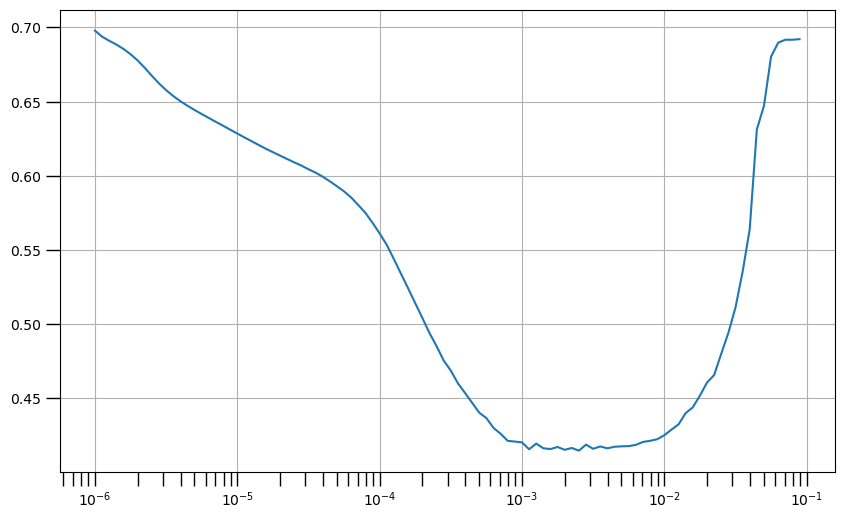

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the learning rate array
lrs = 1e-6 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
#plt.axis([1e-8, 1e-3, 0, 100])

## Training

In [10]:
config_1 = [(32, 'relu'), (10, 'relu')]
input_dim, n_ini, epochs, batch_size,  = int(df_wo.shape[-1])-1, 64, 250, 32 # int(df_wo.shape[-1]), 
learning_rate = ['nonvarying', 2e-3]
validation_split = 0

nn_model, history = train_NN(config_1, X_train_wo, y_train_wo, input_dim, n_ini, epochs, batch_size, validation_split, learning_rate)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-03-15 13:44:17.109071: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1404204032 exceeds 10% of free system memory.


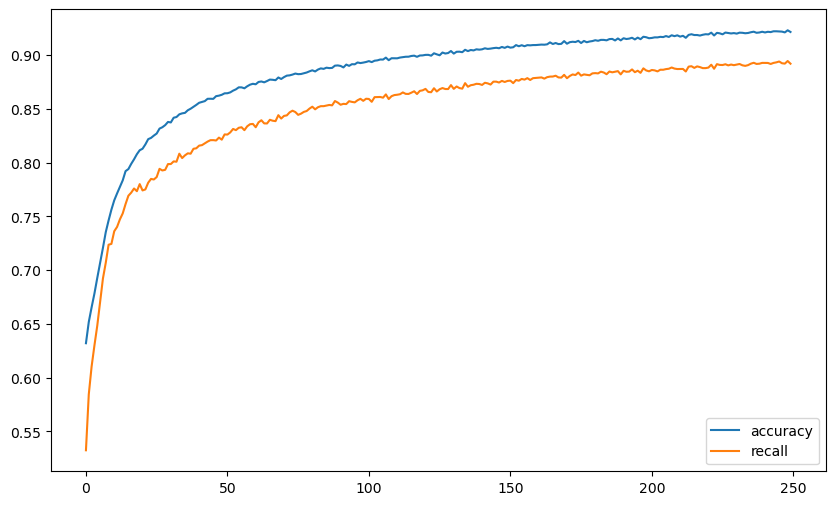

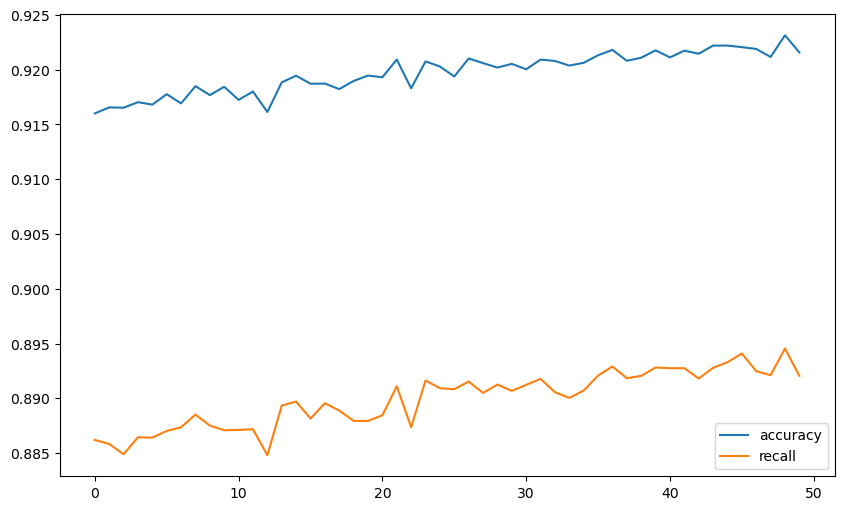

In [11]:


loss = history.history['loss']
accuracy = history.history['accuracy']
recall = history.history['recall']

plt.figure(figsize=(10, 6))
plt.plot(accuracy, label='accuracy')
plt.plot(recall, label='recall')
#plt.plot(loss, label='loss')
plt.legend(loc='lower right')

plt.show()

# Zoomed-in plot
plt.figure(figsize=(10, 6))
plt.plot(accuracy[200:], label='accuracy')
plt.plot(recall[200:], label='recall')
#plt.plot(loss, label='loss')
plt.legend(loc='lower right')

plt.show()

In [14]:
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, recall_score, precision_score

predictions = nn_model.predict(X_test_wo)

new_threshold = 0.3

# Apply the new threshold to determine class labels
new_predictions = (predictions >= new_threshold).astype(int)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test_wo, new_predictions)  # Note: use the probabilities, not the binary predictions
roc_auc = auc(fpr, tpr)

# F1 Score
f1 = f1_score(y_test_wo, new_predictions)

# Recall
recall = recall_score(y_test_wo, new_predictions)


# Confusion Matrix to derive False Positives
tn, fp, fn, tp = confusion_matrix(y_test_wo, new_predictions).ravel()

# Output the calculated metrics
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

253/955 [======>.......................] - ETA: 0s

2024-03-14 21:56:57.987302: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 601807360 exceeds 10% of free system memory.


955/955 [==============================] - 1s 614us/step
Recall: 0.8050600525904342
ROC AUC: 0.5825227354513021
F1 Score: 0.6305067765007096
False Positives: 10534
False Negatives: 2743


In [11]:
config_1 = [(32, 'relu')]
input_dim, n_ini, epochs, batch_size, validation_split, learning_rate = int(df_wo.shape[-1])-1, 16, 100, 32, 0.2, 0.001 # int(df_wo.shape[-1]), 

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30, input_dim=input_dim, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation='sigmoid'),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                73950     
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74271 (290.12 KB)
Trainable params: 74271 (290.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Set the training parameters
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Recall

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=learning_rate))

# Train the model
#model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
history = model.fit(X_train_wo, y_train_wo, batch_size=10, epochs=epochs)

Epoch 1/100


2024-03-14 09:13:36.714110: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1404204032 exceeds 10% of free system memory.


7124/7124 [==============================] - 11s 2ms/step - loss: 0.6319 - accuracy: 0.6374
Epoch 2/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.6140 - accuracy: 0.6529
Epoch 3/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.6049 - accuracy: 0.6621
Epoch 4/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5956 - accuracy: 0.6710
Epoch 5/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5850 - accuracy: 0.6820
Epoch 6/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5755 - accuracy: 0.6891
Epoch 7/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5649 - accuracy: 0.6968
Epoch 8/100
7124/7124 [==============================] - 11s 1ms/step - loss: 0.5555 - accuracy: 0.7065
Epoch 9/100
7124/7124 [==============================] - 11s 1ms/step - loss: 0.5458 - accuracy: 0.7141
Epoch 10/100
7124/7124 [==============================] - 11s 2ms/step - los

In [8]:
# train Logistic Regression model
logreg= train_Logistic(X_train_wo, y_train_wo, max_iter=2000)

In [13]:
from src.features.feature_importance import feature_importance_logreg
imp = feature_importance_logreg(logreg, X_train_wo)

ImportError: cannot import name 'feature_importance_logreg' from 'src.features' (unknown location)

In [18]:
from src.features.feature_importance import pick_top_k_features
pick_top_k_features(X_train_wo, imp, 1000)

NameError: name 'X_train_wo' is not defined

In [19]:
from src.models.DecisionTree import train_DecisionTree
from src.features.feature_importance import feature_importance_other, pick_top_k_features

In [11]:
data = label_and_one_hot_encode(load_data())

/home/hasi/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [12]:
# split the data into train and test
X_train, X_test, y_train, y_test = split_data(data, "readmitted")

# train Decision Tree model
dtree = train_DecisionTree(X_train, y_train, max_depth=10)

NameError: name 'train_DecisionTree' is not defined

In [11]:
evaluate_model(dtree, X_train, X_test, y_train, y_test)

Train accuracy:  0.6564939075748217
Test accuracy:  0.627644939403865


(0.6564939075748217, 0.627644939403865)

In [12]:
# feature importance
imp = feature_importance_other(dtree, X_train)

In [13]:
imp

,importance
number_inpatient,0.380512
discharge_disposition_id,0.172923
number_diagnoses,0.055411
number_emergency,0.035900
admission_source_id,0.032473
...,...
diag_2_155,0.000000
diag_2_156,0.000000
diag_2_157,0.000000
diag_2_162,0.000000


In [30]:
data = label_and_one_hot_encode(load_data())

X_train, X_test, y_train, y_test = split_data(data, "readmitted")

# pick top k features
X_train = pick_top_k_features(X_train, imp, 1000)
X_test = pick_top_k_features(X_test, imp, 1000)

In [33]:
dtree = train_DecisionTree(X_train, y_train, max_depth=15)

In [34]:
evaluate_model(dtree, X_train, X_test, y_train, y_test)

Train accuracy:  0.7086725812791286
Test accuracy:  0.6199148378643957


(0.7086725812791286, 0.6199148378643957)